# Note prediction!

### Simple explorations
1. Handling MIDI files
    * [ ]  How to load a MIDI file and play it in python
    * [ ]  How to convert a MIDI file to audio
2. Audio files
    * [x] Load a wav file?
    * [x] Sampling rate?
    * [x] What does it even look like???
3. Frequency transforms
    * [x] Audio -> STFT
    * [x] Audio -> constant Q transform
    * [x] Visualize each of those!
    
### Setup evaluation metrics
* [ ] GT data for each time frame
* [ ] "evaluate_one_file" or something: P/R/F1
* [ ] Explore the number of classes and statistics

### Naive classifiers
* [ ] Point window, take frequency with the highest amplitude?
* [ ] Sliding window, run CNN on it to make the prediction
    
### Later?
* [ ] What are the MEL features??


## Next steps
### Compare against real baselines
and see where to go next



## NOTES
- At each time step, you are just capturing a "tone". It's not a frequency, not an amplitude, nothing! It'll be the sum of the values of each component sine wave.
- SR determines how many tones samples (tones) you would capture per second
- Based on the values, you can plot or reconstruct the signal
- Using "some analysis" on the signal, you can try to figure out which base frequencies make up the signal - DFT / FFT (optimized)
- However, the audio keeps changing with time (we keep playing more notes and older ones fade away). So, we need to do a similar frequency analysis on shorter time windows. Use Short-Time-Fourier-Transform for this with a constant window size!
- A constant Q transform is another signal analysis technique. This tries to bin the ...?????

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from scipy import signal
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import pathlib
import librosa
%matplotlib inline

### Find the data

In [5]:
path_to_data = pathlib.Path('/home/anuj/data/ftps.tsi.telecom-paristech.fr/share/maps/ENSTDkCl/MUS/')
wav_files = list(path_to_data.glob('**/*.wav'))

### Read one file

In [11]:
wav_file_path = wav_files[0]

data, sr = librosa.load(wav_file_path, sr=None)
data.shape, sr

### Visualize and hear the audio

In [42]:
import librosa.display as ldisplay
import IPython.display as ipydisplay

In [49]:
import math

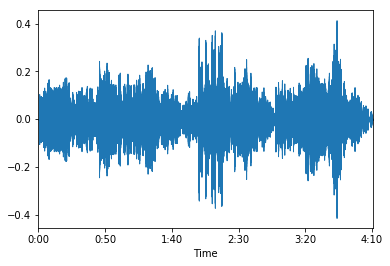

In [33]:
ldisplay.waveplot(data, sr=sr)

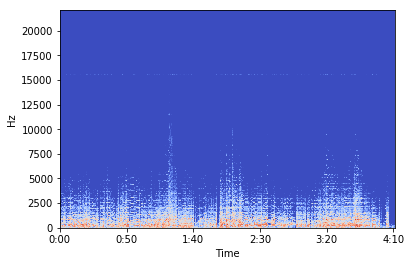

In [63]:
# STFT spectrum
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
ldisplay.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

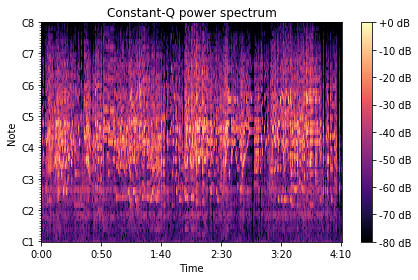

In [62]:
# Constant Q-transform spectrum
C = np.abs(librosa.cqt(data, sr=sr))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [51]:
def get_minutes_seconds(data, sr):
    duration = data.shape[0] / sr / 60
    minutes = math.floor(duration)
    seconds = (duration - minutes) * 60
    print(duration, minutes, seconds)
    return duration, minutes, seconds

In [86]:
get_minutes_seconds(data, sr)

4.183883219954648 4 11.032993197278884


(4.183883219954648, 4, 11.032993197278884)

In [87]:
4.2 * 60

252.0

## Load the ground truth data

In [64]:
annot_file_path = wav_file_path.with_suffix('.txt')

In [77]:
import pandas as pd

In [82]:
df_annot = pd.read_csv(annot_file_path, sep='\t', )

In [85]:
df_annot

,OnsetTime,OffsetTime,MidiPitch
0,0.521985,0.573993,50
1,0.521985,0.574999,57
2,0.727992,0.778002,59
3,0.731989,0.778002,65
4,0.935005,0.979999,60
5,0.935998,0.980992,53
6,1.130000,1.183000,69
7,1.134000,1.184010,62
8,1.344000,1.512000,59
9,1.348000,1.543000,50


In [83]:
df_annot.MidiPitch.value_counts()

62     154
69     144
64     144
67     121
60     112
74     106
72      92
57      86
66      85
71      84
65      84
76      66
59      63
78      59
81      56
55      54
70      47
45      45
52      44
63      42
86      40
73      37
68      35
58      35
61      34
79      32
50      29
53      26
54      25
77      24
      ... 
80      12
51      11
33      10
46       9
36       8
88       8
34       6
90       6
35       5
49       5
42       5
29       5
44       4
85       3
31       3
32       2
28       2
27       2
39       2
91       2
93       2
96       1
98       1
100      1
103      1
37       1
89       1
95       1
101      1
105      1
Name: MidiPitch, Length: 71, dtype: int64

In [84]:
df_annot.MidiPitch.nunique()

71